In [26]:
import os
import sys
from pathlib import Path
import textwrap

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from secret_key import openapi_key

os.environ["OPENAI_API_KEY"] = openapi_key

# Optional model bits
try:
    from sklearn.model_selection import train_test_split
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import accuracy_score, roc_auc_score
    SKLEARN_OK = True
except Exception as _e:
    SKLEARN_OK = False

# Display options
pd.set_option("display.width", 120)
pd.set_option("display.max_columns", 50)

# Reproducibility for any randomness
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [27]:
DATA_PATH = "./kaggle/train.csv"  # change if needed

if not Path(DATA_PATH).exists():
    print(f"[WARN] Could not find {DATA_PATH}. Place your Titanic CSV there or set env var TITANIC_CSV.")
    print("       Proceeding will likely fail on load. Update DATA_PATH above.")
    
# Read the CSV
df = pd.read_csv(DATA_PATH)

# Keep only commonly used columns if present
candidate_cols = ["Survived","Pclass","Sex","Age","SibSp","Parch","Fare","Embarked","Cabin","Name","Ticket","PassengerId"]
present_cols = [c for c in candidate_cols if c in df.columns]
df = df[present_cols].copy()

print("=== HEAD ===")
print(df.head(), "\n")
print("=== INFO ===")
print(df.info(), "\n")
print("=== DESCRIBE (numeric) ===")
print(df.describe(), "\n")
print("=== NULL FRACTIONS ===")
print((df.isna().mean()*100).round(1).sort_values(ascending=False), "%\n")

=== HEAD ===
   Survived  Pclass     Sex   Age  SibSp  Parch     Fare Embarked Cabin  \
0         0       3    male  22.0      1      0   7.2500        S   NaN   
1         1       1  female  38.0      1      0  71.2833        C   C85   
2         1       3  female  26.0      0      0   7.9250        S   NaN   
3         1       1  female  35.0      1      0  53.1000        S  C123   
4         0       3    male  35.0      0      0   8.0500        S   NaN   

                                                Name            Ticket  PassengerId  
0                            Braund, Mr. Owen Harris         A/5 21171            1  
1  Cumings, Mrs. John Bradley (Florence Briggs Th...          PC 17599            2  
2                             Heikkinen, Miss. Laina  STON/O2. 3101282            3  
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)            113803            4  
4                           Allen, Mr. William Henry            373450            5   

=== INFO ===
<clas

In [28]:
# Simple cardinality for categoricals
for col in ["Sex","Embarked","Cabin","Ticket","Name"]:
    if col in df.columns:
        print(f"Unique values in {col}: {df[col].nunique()}")

Unique values in Sex: 2
Unique values in Embarked: 3
Unique values in Cabin: 147
Unique values in Ticket: 681
Unique values in Name: 891


In [29]:
# ========== CLEANING ==========
# Strategy:
# - Age: impute median stratified by Sex & Pclass if available; else global median
# - Embarked: mode impute if missing
# - Cabin: keep boolean has_cabin; leave raw as-is or 'Unknown'
# - Dtypes: ensure categoricals for some columns

# Helper: median-by-group imputation for Age
def impute_age_groupwise(frame: pd.DataFrame) -> pd.Series:
    s = frame["Age"].copy()
    if "Sex" in frame.columns and "Pclass" in frame.columns:
        medians = frame.groupby(["Sex","Pclass"])["Age"].median()
        def fill_fn(row):
            if pd.isna(row["Age"]):
                key = (row.get("Sex", np.nan), row.get("Pclass", np.nan))
                if key in medians.index and pd.notna(medians.loc[key]):
                    return medians.loc[key]
                return frame["Age"].median()
            return row["Age"]
        return frame.apply(fill_fn, axis=1)
    # Fallback: global median
    return s.fillna(frame["Age"].median())

if "Age" in df.columns:
    df["Age"] = impute_age_groupwise(df)

if "Embarked" in df.columns:
    mode_embarked = df["Embarked"].mode(dropna=True)
    if len(mode_embarked):
        df["Embarked"] = df["Embarked"].fillna(mode_embarked.iloc[0])

# Cabin handling
if "Cabin" in df.columns:
    df["HasCabin"] = ~df["Cabin"].isna()
    df["Cabin"] = df["Cabin"].fillna("Unknown")

# Cast common categoricals
for cat_col in ["Sex","Embarked","Pclass"]:
    if cat_col in df.columns:
        df[cat_col] = df[cat_col].astype("category")

print("\n=== AFTER CLEANING: NULL FRACTIONS ===")
print((df.isna().mean()*100).round(1).sort_values(ascending=False), "%\n")



=== AFTER CLEANING: NULL FRACTIONS ===
Survived       0.0
Pclass         0.0
Sex            0.0
Age            0.0
SibSp          0.0
Parch          0.0
Fare           0.0
Embarked       0.0
Cabin          0.0
Name           0.0
Ticket         0.0
PassengerId    0.0
HasCabin       0.0
dtype: float64 %



In [30]:
# ========== FEATURE ENGINEERING ==========
# FamilySize = SibSp + Parch + 1
if set(["SibSp","Parch"]).issubset(df.columns):
    df["FamilySize"] = df["SibSp"].fillna(0) + df["Parch"].fillna(0) + 1
else:
    df["FamilySize"] = np.nan

# AgeGroup bins
if "Age" in df.columns:
    bins = [0, 12, 18, 35, 50, 120]
    labels = ["child","teen","young_adult","adult","senior"]
    df["AgeGroup"] = pd.cut(df["Age"], bins=bins, labels=labels, right=True, include_lowest=True)

# IsAlone from FamilySize
if "FamilySize" in df.columns:
    df["IsAlone"] = (df["FamilySize"] == 1)

# Title extraction from Name (optional, if present)
def extract_title(name: str) -> str:
    if pd.isna(name):
        return "Unknown"
    # very simple parse
    if "," in name and "." in name:
        try:
            return name.split(",")[1].split(".")[0].strip()
        except Exception:
            return "Unknown"
    return "Unknown"

if "Name" in df.columns:
    df["Title"] = df["Name"].astype(str).apply(extract_title).astype("category")

# Fare bucket (optional, for model simplicity)
if "Fare" in df.columns:
    df["FareBucket"] = pd.qcut(df["Fare"].fillna(df["Fare"].median()), q=4, duplicates="drop")


In [31]:
# ========== 6) DESCRIPTIVE STATS & GROUP TABLES ==========
def summarize_by_target(frame: pd.DataFrame, target="Survived"):
    out = {}
    num_cols = frame.select_dtypes(include=[np.number]).columns.tolist()
    for col in num_cols:
        out[col] = frame.groupby(target)[col].agg(["count","mean","std","min","max"])
    return out

if "Survived" in df.columns:
    print("=== NUMERIC SUMMARIES BY Survived ===")
    summaries = summarize_by_target(df, "Survived")
    for k, v in summaries.items():
        print(f"\n-- {k} --\n{v}")

=== NUMERIC SUMMARIES BY Survived ===

-- Survived --
          count  mean  std  min  max
Survived                            
0           549   0.0  0.0    0    0
1           342   1.0  0.0    1    1

-- Age --
          count       mean        std   min   max
Survived                                         
0           549  29.737705  12.818264  1.00  74.0
1           342  28.108684  14.010565  0.42  80.0

-- SibSp --
          count      mean       std  min  max
Survived                                     
0           549  0.553734  1.288399    0    8
1           342  0.473684  0.708688    0    4

-- Parch --
          count      mean       std  min  max
Survived                                     
0           549  0.329690  0.823166    0    6
1           342  0.464912  0.771712    0    5

-- Fare --
          count       mean        std  min       max
Survived                                            
0           549  22.117887  31.388207  0.0  263.0000
1           342  48.39

In [32]:
# Grouped survival rates by key segments
def survival_rate_by(frame: pd.DataFrame, by_cols):
    if "Survived" not in frame.columns:
        return pd.DataFrame()
    grp = frame.groupby(by_cols)["Survived"].mean().reset_index()
    grp.rename(columns={"Survived":"Survival_Rate"}, inplace=True)
    return grp.sort_values("Survival_Rate", ascending=False)

key_groups = []
for cols in (
    ["Sex"],
    ["Pclass"],
    ["AgeGroup"],
    ["Embarked"],
    ["IsAlone"],
    ["Sex","Pclass"],
    ["Sex","AgeGroup"],
):
    present = [c for c in cols if c in df.columns]
    if present and "Survived" in df.columns:
        table = survival_rate_by(df, present)
        key_groups.append((present, table))

print("\n=== SURVIVAL RATES BY GROUP ===")
for cols, table in key_groups:
    print(f"\nBy {cols}:\n{table.to_string(index=False)}")


=== SURVIVAL RATES BY GROUP ===

By ['Sex']:
   Sex  Survival_Rate
female       0.742038
  male       0.188908

By ['Pclass']:
Pclass  Survival_Rate
     1       0.629630
     2       0.472826
     3       0.242363

By ['AgeGroup']:
   AgeGroup  Survival_Rate
      child       0.579710
       teen       0.428571
      adult       0.379310
young_adult       0.357977
     senior       0.343750

By ['Embarked']:
Embarked  Survival_Rate
       C       0.553571
       Q       0.389610
       S       0.339009

By ['IsAlone']:
 IsAlone  Survival_Rate
   False       0.505650
    True       0.303538

By ['Sex', 'Pclass']:
   Sex Pclass  Survival_Rate
female      1       0.968085
female      2       0.921053
female      3       0.500000
  male      1       0.368852
  male      2       0.157407
  male      3       0.135447

By ['Sex', 'AgeGroup']:
   Sex    AgeGroup  Survival_Rate
female      senior       0.941176
female young_adult       0.751445
female        teen       0.750000
female       a

C:\Users\benny\AppData\Local\Temp\ipykernel_22900\1040639912.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = frame.groupby(by_cols)["Survived"].mean().reset_index()
C:\Users\benny\AppData\Local\Temp\ipykernel_22900\1040639912.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = frame.groupby(by_cols)["Survived"].mean().reset_index()
C:\Users\benny\AppData\Local\Temp\ipykernel_22900\1040639912.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the futu

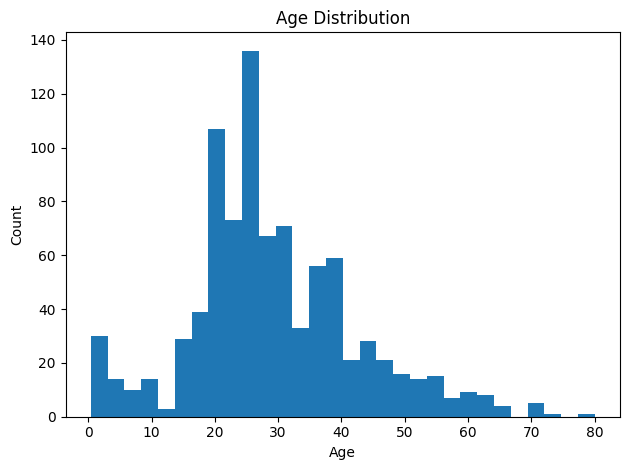

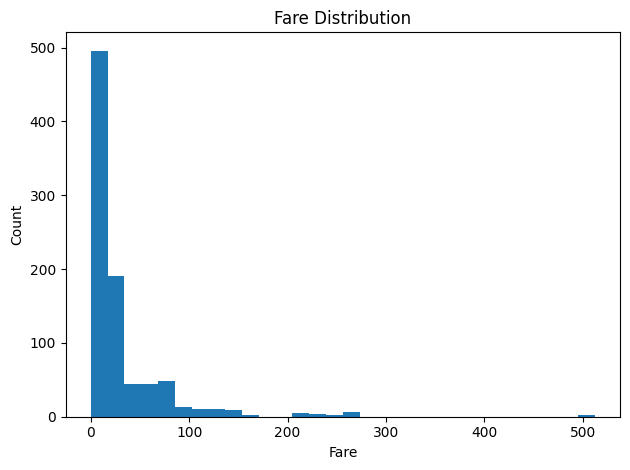

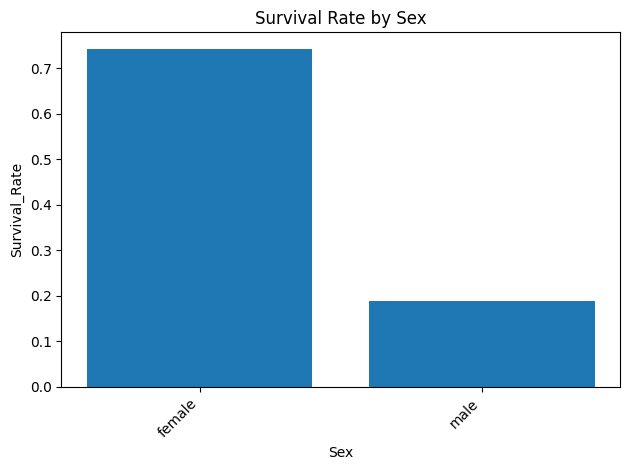

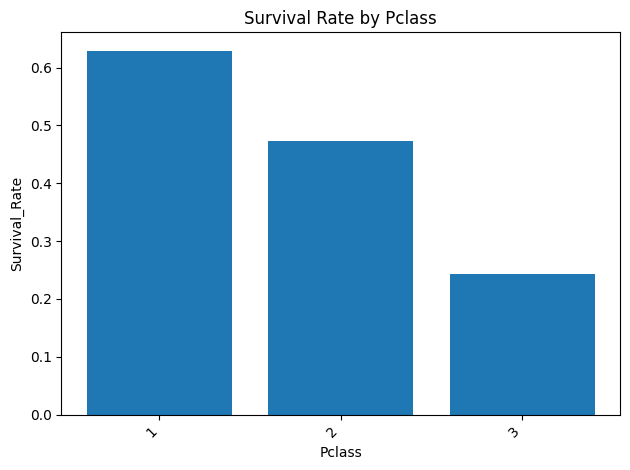

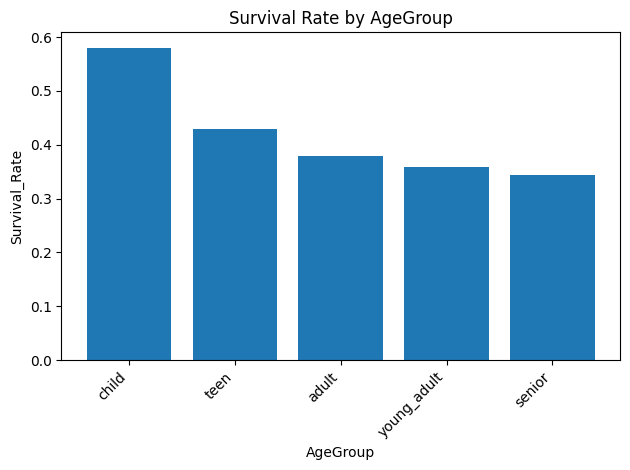

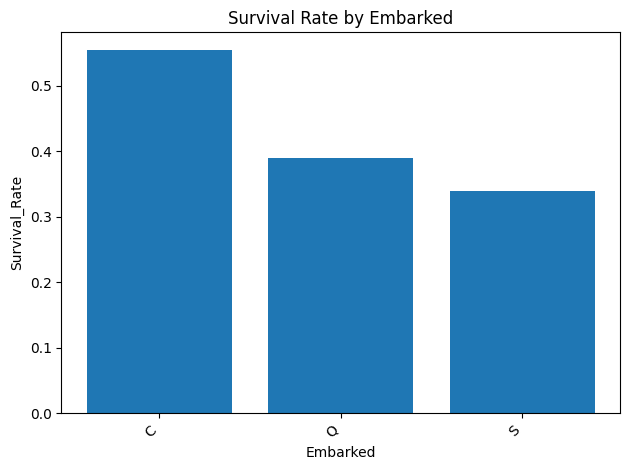

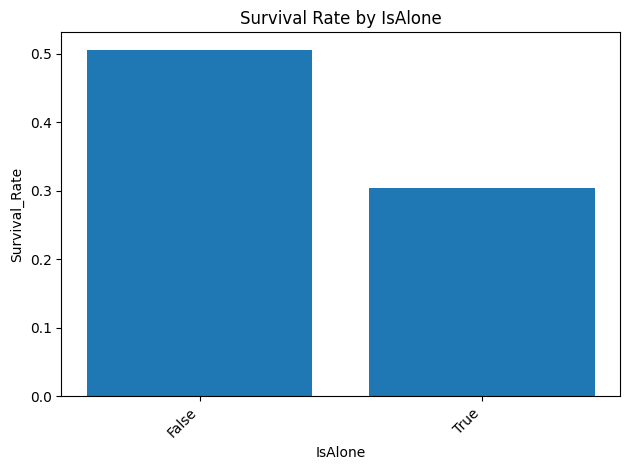

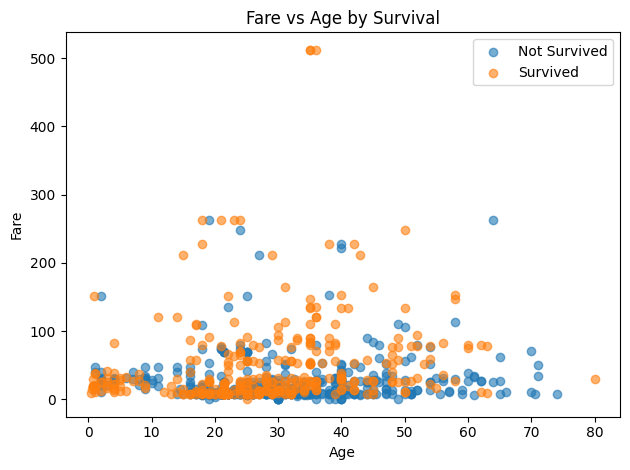

In [33]:
# ========== VISUALIZATIONS (one plot per figure; no seaborn) ==========
def safe_hist(series, title):
    plt.figure()
    series.dropna().plot(kind="hist", bins=30)
    plt.title(title)
    plt.xlabel(series.name)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

def bar_from_group(df_group, x_col, y_col, title):
    plt.figure()
    plt.bar(df_group[x_col].astype(str), df_group[y_col].values)
    plt.title(title)
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

# Histograms
if "Age" in df.columns:
    safe_hist(df["Age"], "Age Distribution")
if "Fare" in df.columns:
    safe_hist(df["Fare"], "Fare Distribution")

# Bar charts for key categorical survival rates
for cols, table in key_groups:
    if len(cols) == 1:
        x_col = cols[0]
        bar_from_group(table, x_col, "Survival_Rate", f"Survival Rate by {x_col}")

# Example scatter (Fare vs Age) colored by Survived via simple marker split
if set(["Fare","Age","Survived"]).issubset(df.columns):
    plt.figure()
    plt.scatter(df.loc[df["Survived"] == 0, "Age"], df.loc[df["Survived"] == 0, "Fare"], alpha=0.6, label="Not Survived")
    plt.scatter(df.loc[df["Survived"] == 1, "Age"], df.loc[df["Survived"] == 1, "Fare"], alpha=0.6, label="Survived")
    plt.title("Fare vs Age by Survival")
    plt.xlabel("Age")
    plt.ylabel("Fare")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [34]:
# ========== BUILD LLM-READY TABLE ==========
def llm_ready_table(frame: pd.DataFrame):
    cols = []
    for c in ["Sex","Pclass","AgeGroup"]:
        if c in frame.columns:
            cols.append(c)
    if not cols:
        # Fallback to Sex and Pclass if possible, else just Sex
        for c in ["Sex","Pclass"]:
            if c in frame.columns and c not in cols:
                cols.append(c)
    if "Survived" not in frame.columns:
        return pd.DataFrame()
    gcols = cols[:2] if len(cols) > 2 else cols  # keep compact
    if not gcols:
        return pd.DataFrame()
    agg = (
        frame.groupby(gcols)
        .agg(
            Count=("Survived","size"),
            Avg_Age=("Age","mean"),
            Avg_Fare=("Fare","mean"),
            Survival_Rate=("Survived","mean"),
        )
        .reset_index()
    )
    # Round for readability
    for c in ["Avg_Age","Avg_Fare","Survival_Rate"]:
        if c in agg.columns:
            agg[c] = agg[c].round(3)
    return agg

llm_table = llm_ready_table(df)
print("\n=== LLM-READY TABLE ===")
print(llm_table)

# Basic Markdown rendering
def df_to_markdown(frame: pd.DataFrame) -> str:
    if frame.empty:
        return "*(No data)*"
    header = "| " + " | ".join(frame.columns.astype(str)) + " |"
    sep = "| " + " | ".join(["---"] * len(frame.columns)) + " |"
    rows = ["| " + " | ".join(map(str, row)) + " |" for row in frame.values]
    return "\n".join([header, sep] + rows)


=== LLM-READY TABLE ===
      Sex Pclass  Count  Avg_Age  Avg_Fare  Survival_Rate
0  female      1     94   34.649   106.126          0.968
1  female      2     76   28.704    21.970          0.921
2  female      3    144   21.677    16.119          0.500
3    male      1    122   41.061    67.226          0.369
4    male      2    108   30.679    19.742          0.157
5    male      3    347   26.099    12.662          0.135


C:\Users\benny\AppData\Local\Temp\ipykernel_22900\3704766640.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  frame.groupby(gcols)


In [ ]:
# Also emit a suggested prompt
prompt_text = textwrap.dedent("""
You are a careful data analyst. Use the following aggregated table from a Titanic survival analysis to explain patterns clearly and cautiously.

<DATA_TABLE>
{table}
</DATA_TABLE>

Questions:
1) Summarize which factors most influenced survival.
2) Explain why children might have had higher survival rates than adults.
3) Suggest one feature I could create that might improve insights about survival.
4) Which passenger group had the highest survival rate?

Answer in tight, numbered bullets with short justifications grounded in the table. Refer to general domain knowledge if needed.
""").strip()

In [38]:
# LLM analysis

pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_colwidth', None)  # Show full column width
pd.set_option('display.width', None)  # Don't wrap to fit console width

if "OPENAI_API_KEY" in os.environ and SKLEARN_OK:
    from langchain import OpenAI
    from langchain.chains import LLMChain
    from langchain.prompts import PromptTemplate

    if llm_table.empty:
        print("[SKIP] LLM analysis skipped due to empty LLM-ready table.")
        sys.exit(0)

    print("\n=== LLM ANALYSIS ===")
    llm = OpenAI(temperature=0)
    prompt = PromptTemplate(
        input_variables=["table"],
        template=prompt_text,
    )
    chain = LLMChain(llm=llm, prompt=prompt)
    response = chain.run(table=df_to_markdown(llm_table))
    print(response)



=== LLM ANALYSIS ===


1) Factors that most influenced survival were:
- Sex: Females had a significantly higher survival rate (0.968) compared to males (0.369).
- Pclass: Passengers in first class had a higher survival rate (0.968) compared to those in second (0.921) and third class (0.5).
- Age: Passengers in the younger age group (children) had a higher survival rate compared to adults. 

2) Children might have had higher survival rates than adults due to:
- Priority in evacuation: Children were given priority during the evacuation process, which could have increased their chances of survival.
- Physical ability: Children may have been physically smaller and more agile, making it easier for them to navigate through the ship and escape.
- Protective instincts: Parents and caregivers may have prioritized the safety of children, leading to higher survival rates for this age group.

3) One feature that could improve insights about survival is the presence of family members. This could b